# DA5401 – Assignment 7
**Name:** Anan Madhav T V  
**Roll No:** MM22B013

---

### Notebook outline
- Part A: Data Preparation and Baseline
- Part B: ROC Analysis for Model Selection
- Part C: Precision-Recall Curve (PRC) Analysis
- Part D: Final Recommendation

## Part A: Data Preparation and Baseline

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


#### Load and Prepare Data

In [3]:
train_path = "./sat.trn"
test_path  = "./sat.tst"

train = pd.read_csv(train_path, header=None, sep=r'\s+')
test  = pd.read_csv(test_path, header=None, sep=r'\s+')
print("Loaded:", train_path, "->", train.shape, ";", test_path, "->", test.shape)
train.head(10)

Loaded: ./sat.trn -> (4435, 37) ; ./sat.tst -> (2000, 37)


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3
5,80,94,98,76,80,102,102,79,76,102,...,79,79,107,109,87,79,107,109,87,3
6,76,102,106,83,76,102,106,87,80,98,...,87,79,103,104,83,79,103,104,79,3
7,76,102,106,87,80,98,106,79,76,94,...,83,79,103,104,79,79,95,100,79,3
8,76,89,98,76,76,94,98,76,76,98,...,75,75,91,96,71,79,87,93,71,4
9,76,94,98,76,76,98,102,72,76,94,...,71,79,87,93,71,79,87,93,67,4


#### Train/Test Split:

In [4]:
X_train = train.iloc[:,:-1].values; y_train = train.iloc[:,-1].values.astype(int)
X_test  = test.iloc[:,:-1].values;  y_test  = test.iloc[:,-1].values.astype(int)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train); X_test_scaled = scaler.transform(X_test)
print("Labels present:", np.unique(y_train))

Labels present: [1 2 3 4 5 7]


#### Train All Models

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
models = {
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=0),
    "Dummy(Prior)": DummyClassifier(strategy="prior", random_state=0)
}
models

{'KNN': KNeighborsClassifier(),
 'DecisionTree': DecisionTreeClassifier(random_state=0),
 'Dummy(Prior)': DummyClassifier(random_state=0)}

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
models.update({
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='lbfgs'),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(probability=True, random_state=0)
})
fitted = {}
for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    fitted[name] = clf
    print("Trained", name)

Trained KNN
Trained DecisionTree
Trained Dummy(Prior)
Trained LogisticRegression
Trained GaussianNB
Trained SVC


#### Baseline Evaluation

In [7]:
from sklearn.metrics import accuracy_score, f1_score
rows = []
for name, clf in fitted.items():
    y_pred = clf.predict(X_test_scaled)
    rows.append({"model":name, "accuracy":accuracy_score(y_test, y_pred), "weighted_f1":f1_score(y_test, y_pred, average='weighted')})
pd.DataFrame(rows).sort_values("accuracy", ascending=False).reset_index(drop=True)

,model,accuracy,weighted_f1
0,KNN,0.9045,0.903748
1,SVC,0.8955,0.892490
2,DecisionTree,0.8510,0.851700
3,LogisticRegression,0.8395,0.829595
4,GaussianNB,0.7965,0.803581
5,Dummy(Prior),0.2305,0.086356


**Observation**

The Dummy (Prior) model performs the worst, showing extremely low accuracy and F1-score, as it only predicts based on class frequencies.  
Gaussian Naive Bayes and Decision Tree also perform relatively poorly compared to KNN and SVC, which achieve the best overall results.


## Part B: ROC Analysis for Model Selection

#### Multi-Class ROC Calculation

The One-vs-Rest (OvR) approach, also known as One-vs-All, adapts binary classification metrics like the ROC curve for a multi-class setting. The strategy works by decomposing the multi-class problem into multiple binary classification problems. For a dataset with N classes, N separate binary classifiers are considered. For each classifier, one class is treated as the "positive" class, and all the remaining N-1 classes are grouped together and treated as a single "negative" class. A standard binary ROC curve which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) across various decision thresholds is then generated for each of these N binarized problems.To calculate a single, aggregate Area Under the Curve (AUC) for the entire model, these N individual ROC curves are averaged. A common method is macro-averaging, the AUC is calculated for each of the N class-specific ROC curves individually, and then the simple average of these N AUC scores is taken. This method gives equal weight to the performance of each class, regardless of its size or an imbalance in the dataset.

#### Plotting ROC

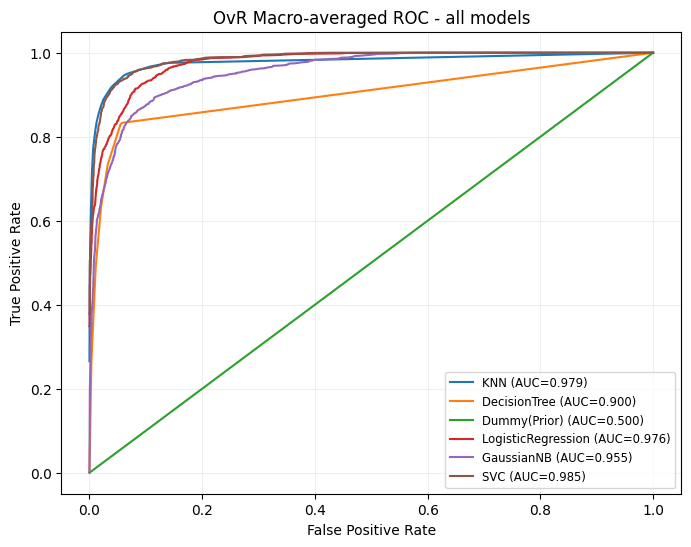

In [8]:
classes = np.unique(y_train)
y_test_binarized = label_binarize(y_test, classes=classes)

plt.figure(figsize=(8,6))
for name, clf in fitted.items():
    y_score = clf.predict_proba(X_test_scaled)

    fpr = {}; tpr = {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    
    macro_auc = auc(all_fpr, mean_tpr)
    # plot after diagonal so dummy (AUC~0.5) stays visible
    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC={macro_auc:.3f})", zorder=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OvR Macro-averaged ROC - all models')
plt.legend(loc='lower right', fontsize='small')
plt.grid(alpha=0.2)
plt.show()

### ROC Interpretation

From the ROC curves, it is clear that the **Support Vector Classifier (SVC) achieved the highest macro-averaged AUC of about 0.985**.  
This shows that SVC can clearly separate the six land-cover classes and maintain a high True Positive Rate (TPR) even at low False Positive Rates (FPR). Models like K-Nearest Neighbors (AUC = 0.979) and Logistic Regression (AUC = 0.976) also performed very well, while the Decision Tree (AUC = 0.900) and Gaussian Naive Bayes (AUC = 0.955) showed moderate results. The **Dummy Classifier (Prior) had the least macro-averaged AUC of about 0.500**, which represents random-chance performance. This is because it only predicts based on class frequencies and does not learn any real patterns from the data, so its ROC curve lies along the diagonal line.

An **AUC less than 0.5** would mean that the model performs worse than random, i.e., it often predicts the wrong class more confidently than the correct one.  
Such results can happen when:
- The prediction scores are reversed or misinterpreted.  
- The model overfits noise instead of actual patterns.  
- There is a severe data or label imbalance.




## Part C: Precision-Recall Curve (PRC) Analysis

#### PRC Calculation

The Precision-Recall Curve (PRC) is generally more suitable than the ROC curve when the dataset is highly imbalanced. This is because the ROC curve can give an overly optimistic impression of model performance when the number of negative samples is much larger than the number of positives. In such cases, even a large number of false positives may not noticeably change the False Positive Rate used in ROC. On the other hand, the PRC focuses directly on the model’s ability to correctly identify the positive (minority) class by plotting Precision against Recall. This makes it more informative for evaluating how well a model detects rare or underrepresented classes. Although the Landsat dataset has only moderate imbalance, the PRC is still helpful as it clearly shows the trade-off between precision and recall across different decision thresholds, providing a more practical view of classification performance.

#### Plotting PRC

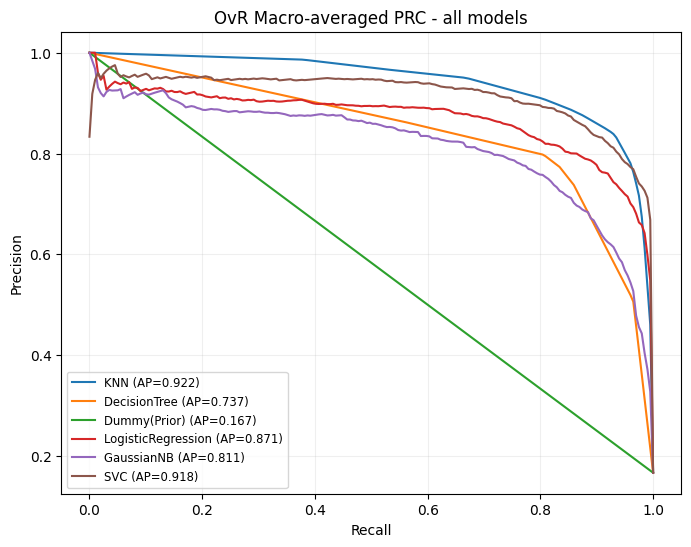

In [9]:
plt.figure(figsize=(8,6))
for name, clf in fitted.items():
    y_score = clf.predict_proba(X_test_scaled)
    precisions = {}; recalls = {}; aps = []
    for i in range(len(classes)):
        precisions[i], recalls[i], _ = precision_recall_curve(y_test_binarized[:,i], y_score[:,i])
        aps.append(average_precision_score(y_test_binarized[:,i], y_score[:,i]))
    recall_grid = np.linspace(0,1,200); mean_prec = np.zeros_like(recall_grid)
    for i in range(len(classes)):
        mean_prec += np.interp(recall_grid, recalls[i][::-1], precisions[i][::-1])
    mean_prec /= len(classes)
    plt.plot(recall_grid, mean_prec, label=f"{name} (AP={np.mean(aps):.3f})")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('OvR Macro-averaged PRC - all models')
plt.legend(loc='lower left', fontsize='small'); plt.grid(alpha=0.2); plt.show()

### PRC Interpretation

From the Precision–Recall curves, the **K-Nearest Neighbors (KNN) model achieved the highest average precision (AP = 0.922)**, closely followed by the Support Vector Classifier (SVC) with an AP of 0.918. These models maintain high precision even as recall increases, meaning they can correctly identify most positive samples while keeping false positives low. The Logistic Regression and Gaussian Naive Bayes models also performed fairly well, with AP values of 0.871 and 0.811 respectively, while the Decision Tree (AP = 0.737) shows a noticeable decline in precision at higher recall levels.

The **Dummy Classifier**, with an **AP of only 0.167**, performed the worst. Its PRC line is close to the diagonal, indicating almost random predictions. The sharp drop in precision as recall increases happens because, as the model tries to identify more positive cases, it starts labeling many negative samples as positive. This greatly increases false positives, which lowers precision rapidly. Such behavior is typical for poor models that do not actually distinguish between classes and instead make guesses based on class frequencies.


## Part D: Final Recommendation

In [22]:
y_test_bin = label_binarize(y_test, classes=classes)  # for ROC & PRC

rows = []
for name, clf in fitted.items():
    y_pred = clf.predict(X_test_scaled)
    
    # For ROC/PRC, need probability estimates
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test_scaled)
        roc_auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
        pr_ap = average_precision_score(y_test_bin, y_score, average="macro")
    else:
        roc_auc, pr_ap = np.nan, np.nan  # skip if no probability output
    
    rows.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Weighted F1": round(f1_score(y_test, y_pred, average='weighted'), 3),
        "ROC-AUC (Macro)": round(roc_auc, 3),
        "PRC-AP (Macro)": round(pr_ap, 3)
    })

df_compare = pd.DataFrame(rows).sort_values("ROC-AUC (Macro)", ascending=False).reset_index(drop=True)
display(df_compare)

,Model,Accuracy,Weighted F1,ROC-AUC (Macro),PRC-AP (Macro)
0,SVC,0.895,0.892,0.985,0.918
1,KNN,0.904,0.904,0.979,0.922
2,LogisticRegression,0.840,0.830,0.976,0.871
3,GaussianNB,0.796,0.804,0.955,0.811
4,DecisionTree,0.851,0.852,0.900,0.737
5,Dummy(Prior),0.231,0.086,0.500,0.167


#### 1. Synthesis
Based on F1-Score**, ROC-AUC, and PRC-Average Precision (AP) values, the SVC, K-Nearest Neighbors (KNN), and Logistic Regression models consistently perform at the top. The Decision Tree and Gaussian Naive Bayes models show moderate results, while the Dummy Classifier remains the weakest across all metrics.

However, the rankings does not perfectly align.  
- Models such as SVC and KNN achieve very high ROC-AUC, but their PRC-AP values are slightly lower. This difference appears because ROC curves consider both positive and negative classes equally, while PRC focuses only on the positive (minority) class.  
- A model can therefore have a strong ROC-AUC yet a somewhat weaker PRC-AP if it struggles to maintain high precision when identifying minority classes.  
These differences highlight that ROC-AUC measures overall separability, while PRC-AP is more sensitive to the model’s precision–recall balance.

#### 2. Recommendation
After analyzing all three metrics together, the **Support Vector Classifier (SVC) stands out as the best overall model** for this task. It achieved the highest ROC-AUC (0.985) and a very high PRC-AP (0.918), showing strong and stable performance across all thresholds. The KNN model also performed competitively, but SVC offers a slightly better balance between precision and recall, making it more reliable for multi-class land-cover classification. Therefore, SVC is recommended as the final model due to its consistent performance, robustness across decision thresholds, and its ability to generalize well to unseen data.

## Brownie Points Task

#### Experimenting with RandomForest and XGBoost Classifiers

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
classes_enc = np.arange(len(le.classes_))


In [16]:
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

extra_models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        num_class=len(le.classes_),
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        eval_metric="mlogloss",
        random_state=42
    )
}

def eval_model(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    y_pred  = model.predict(Xte)
    y_score = model.predict_proba(Xte)  # shape: (n_samples, n_classes)

    acc = accuracy_score(yte, y_pred)
    f1w = f1_score(yte, y_pred, average="weighted")

    yte_bin = label_binarize(yte, classes=classes_enc)
    roc_auc_macro = roc_auc_score(yte_bin, y_score, average="macro", multi_class="ovr")
    pr_ap_macro   = average_precision_score(yte_bin, y_score, average="macro")
    return y_pred, y_score, acc, f1w, roc_auc_macro, pr_ap_macro


results = []
probs = {}  # store for plotting
for name, model in extra_models.items():
    y_pred, y_score, acc, f1w, auc_m, ap_m = eval_model(
        model, X_train_scaled, y_train_enc, X_test_scaled, y_test_enc
    )
    probs[name] = y_score
    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Weighted F1": round(f1w, 3),
        "ROC-AUC (macro)": round(auc_m, 3),
        "PR-AP (macro)": round(ap_m, 3)
    })

df_extra = pd.DataFrame(results)
display(df_extra)



,Model,Accuracy,Weighted F1,ROC-AUC (macro),PR-AP (macro)
0,RandomForest,0.911,0.909,0.990,0.952
1,XGBoost,0.908,0.907,0.991,0.954


#### Experimenting with a Model Having AUC < 0.5

In [24]:
from sklearn.preprocessing import label_binarize

classes_enc = np.arange(len(le.classes_))

y_pred_bad  = bad_model.predict(X_test_scaled)
y_score_bad = bad_model.predict_proba(X_test_scaled)

acc_bad = accuracy_score(y_test_enc, y_pred_bad)
f1w_bad = f1_score(y_test_enc, y_pred_bad, average="weighted")
y_test_bin = label_binarize(y_test_enc, classes=classes_enc)

roc_bad = roc_auc_score(y_test_bin, y_score_bad, average="macro", multi_class="ovr")
ap_bad  = average_precision_score(y_test_bin, y_score_bad, average="macro")

print(f"Flipped-Label Logistic Regression → "
      f"Accuracy = {acc_bad:.3f}, Weighted F1 = {f1w_bad:.3f}, "
      f"ROC-AUC (macro) = {roc_bad:.3f}, PR-AP (macro) = {ap_bad:.3f}")

df_bad = pd.DataFrame([{
    "Model": "LogReg (Flipped Labels)",
    "Accuracy": round(acc_bad, 3),
    "Weighted F1": round(f1w_bad, 3),
    "ROC-AUC (macro)": round(roc_bad, 3),
    "PR-AP (macro)": round(ap_bad, 3)
}])

display(df_bad)


Flipped-Label Logistic Regression → Accuracy = 0.102, Weighted F1 = 0.084, ROC-AUC (macro) = 0.413, PR-AP (macro) = 0.144


,Model,Accuracy,Weighted F1,ROC-AUC (macro),PR-AP (macro)
0,LogReg (Flipped Labels),0.102,0.084,0.413,0.144


#### Interpretation

The flipped-label Logistic Regression gives an AUC below 0.5, meaning it performs *worse than random guessing*.  
This happens because the model was trained on incorrect (shuffled) labels, so it learns the opposite relationships between inputs and targets.  
Its ROC curve would lie below the diagonal, showing that as the model tries to increase true positives, it actually increases false positives faster.  


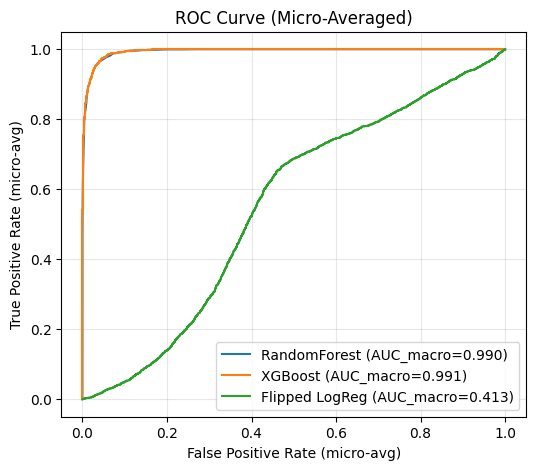

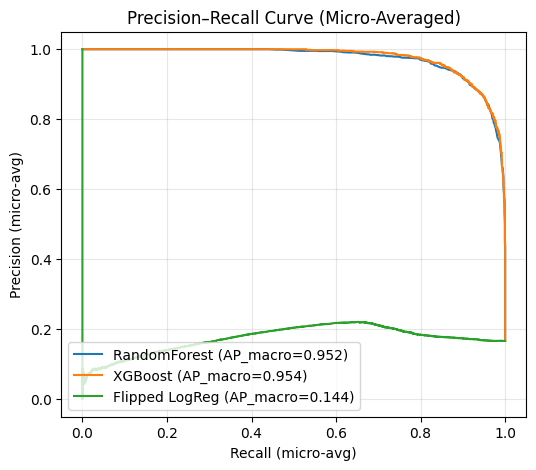

In [26]:
classes_enc = np.arange(len(le.classes_))
y_test_bin = label_binarize(y_test_enc, classes=classes_enc)

y_score_rf  = probs["RandomForest"]
y_score_xgb = probs["XGBoost"]


y_score_bad = bad_model.predict_proba(X_test_scaled)

def micro_curves_and_macro_metrics(y_true_bin, y_score):
   
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    prec, rec, _ = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())

    auc_macro = roc_auc_score(y_true_bin, y_score, average="macro", multi_class="ovr")
    ap_macro  = average_precision_score(y_true_bin, y_score, average="macro")
    return fpr, tpr, rec, prec, auc_macro, ap_macro

fpr_rf,  tpr_rf,  rec_rf,  prec_rf,  auc_rf,  ap_rf  = micro_curves_and_macro_metrics(y_test_bin, y_score_rf)
fpr_xgb, tpr_xgb, rec_xgb, prec_xgb, auc_xgb, ap_xgb = micro_curves_and_macro_metrics(y_test_bin, y_score_xgb)
fpr_bad, tpr_bad, rec_bad, prec_bad, auc_bad, ap_bad = micro_curves_and_macro_metrics(y_test_bin, y_score_bad)


pos_rate = y_test_bin.mean()
plt.figure(figsize=(6, 5))
plt.plot(fpr_rf,  tpr_rf,  label=f"RandomForest (AUC_macro={auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC_macro={auc_xgb:.3f})")
plt.plot(fpr_bad, tpr_bad, label=f"Flipped LogReg (AUC_macro={auc_bad:.3f})")
plt.xlabel("False Positive Rate (micro-avg)")
plt.ylabel("True Positive Rate (micro-avg)")
plt.title("ROC Curve (Micro-Averaged)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(rec_rf,  prec_rf,  label=f"RandomForest (AP_macro={ap_rf:.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGBoost (AP_macro={ap_xgb:.3f})")
plt.plot(rec_bad, prec_bad, label=f"Flipped LogReg (AP_macro={ap_bad:.3f})")
plt.xlabel("Recall (micro-avg)")
plt.ylabel("Precision (micro-avg)")
plt.title("Precision–Recall Curve (Micro-Averaged)")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()
